# Job Posting Data Acquisition and EDA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import string

from gensim.models import CoherenceModel, ldamulticore
from gensim import utils
from gensim.test.utils import common_corpus, common_dictionary

from dfunc import df_info
from dfunc import chi_sq
from dfunc import feat_to_dum
from dfunc import get_scores

sns.set_style('whitegrid')
%matplotlib inline

np.random.seed(0)
pd.set_option('display.max_columns', 300)

In [3]:
df = pd.read_csv('fake_job_postings.csv', index_col=0)

## Initial Data Cleaning/Engineering and EDA
- Total Observations: 17880 rows
- Total Features: 16 columns
- Target Variable: 'fraudulent', 0 is real, 1 is false
    - 0: 17014
    - 1: 866
- Features to drop:
    - 'title': No standardization of naming job titles, >1000 different titles
- Categorical Features: 'location', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function'
- NLP Features: 'company_profile', 'description', 'requirements', 'benefits'

In [4]:
target = 'fraudulent'

In [ ]:
df_info(df, target)

In [5]:
# Drop 'title'
df.drop(columns=['title'], inplace=True)

### Narrow down to US job postings
- 10656 total observations, 730 fake and 9926 real
- Minority class: 6.85%, Majority class: 93.15%

In [6]:
# Only keeping US job postings
df = df.loc[df['location'].str[:2] == 'US']

### Run Chi-squared tests on features with missing values
- Null Hypotheses: The proportions of false job reportings for null feature values and non-null feature values are equal
- Drop 'function', too many categories, too many missing values, low chi-sq
- Drop 'industry, too many categories, too many missing values, low chi-sq

In [7]:
chi_sq(df, feature='department', target=target)

Reject Null Hypothesis
Chi-Squared: 66.3287
p-value: 0.0

Posting Fake when NaN: 5.59%
Posting Real when NaN: 94.41%
Posting Fake when non-null: 10.01%
Posting Real when non-null: 89.99%


In [8]:
chi_sq(df, feature='required_education', target=target)

Reject Null Hypothesis
Chi-Squared: 12.3865
p-value: 0.002

Posting Fake when NaN: 7.86%
Posting Real when NaN: 92.14%
Posting Fake when non-null: 6.12%
Posting Real when non-null: 93.88%


In [9]:
chi_sq(df, feature='required_experience', target=target)

Reject Null Hypothesis
Chi-Squared: 16.2374
p-value: 0.0003

Posting Fake when NaN: 8.05%
Posting Real when NaN: 91.95%
Posting Fake when non-null: 6.04%
Posting Real when non-null: 93.96%


In [10]:
chi_sq(df, feature='industry', target=target)

Cannot Reject Null Hypothesis
Chi-Squared: 1.8199
p-value: 0.4025

Posting Fake when NaN: 7.42%
Posting Real when NaN: 92.58%
Posting Fake when non-null: 6.66%
Posting Real when non-null: 93.34%


In [11]:
chi_sq(df, feature='function', target=target)

Cannot Reject Null Hypothesis
Chi-Squared: 2.914
p-value: 0.2329

Posting Fake when NaN: 6.3%
Posting Real when NaN: 93.7%
Posting Fake when non-null: 7.17%
Posting Real when non-null: 92.83%


In [12]:
chi_sq(df, feature='employment_type', target=target)

Reject Null Hypothesis
Chi-Squared: 48.2519
p-value: 0.0

Posting Fake when NaN: 10.67%
Posting Real when NaN: 89.33%
Posting Fake when non-null: 6.09%
Posting Real when non-null: 93.91%


In [13]:
chi_sq(df, feature='salary_range', target=target)

Reject Null Hypothesis
Chi-Squared: 65.1333
p-value: 0.0

Posting Fake when NaN: 6.03%
Posting Real when NaN: 93.97%
Posting Fake when non-null: 11.62%
Posting Real when non-null: 88.38%


In [14]:
chi_sq(df, feature='company_profile', target=target)

Reject Null Hypothesis
Chi-Squared: 1013.4112
p-value: 0.0

Posting Fake when NaN: 22.69%
Posting Real when NaN: 77.31%
Posting Fake when non-null: 3.02%
Posting Real when non-null: 96.98%


In [15]:
chi_sq(df, feature='requirements', target=target)

Cannot Reject Null Hypothesis
Chi-Squared: 0.7604
p-value: 0.6837

Posting Fake when NaN: 7.33%
Posting Real when NaN: 92.67%
Posting Fake when non-null: 6.76%
Posting Real when non-null: 93.24%


In [16]:
chi_sq(df, feature='benefits', target=target)

Cannot Reject Null Hypothesis
Chi-Squared: 2.5693
p-value: 0.2767

Posting Fake when NaN: 6.41%
Posting Real when NaN: 93.59%
Posting Fake when non-null: 7.2%
Posting Real when non-null: 92.8%


In [17]:
# Drop columns
df.drop(columns=['industry', 'function', 'requirements', 'benefits'], inplace=True)

### Salary range feature
- Ratio of fake to real job postings is much greater in postings that include salary range
- Convert feature to whether or not salary is posted

In [18]:
# Create salary dummy
df['salary_range'] = np.where(df['salary_range'].isna() == True, 0, 1)

### Clean location feature
- Replace with state dummies

In [19]:
# Create 'state' feature, if no state exists then 'no state'
condition = df['location'].str.extract(r'([A-Z]{2}(?<!US))').notnull()
value = df['location'].str.extract(r'([A-Z]{2}(?<!US))')
df['state'] = np.where(condition, value, 'No State')
df['state'] = np.where((df['state'] == 'AU') | (df['state'] == 'LO'), 'No State', df['state'])
df.drop(columns='location', inplace=True)

In [20]:
df = feat_to_dum(df, 'state', s_value='Unspecified', pref=None)

Feature Dummied and Dropped: state


### Department feature
- Convert to dummy, too many different categories with no standardization

In [21]:
# Convert department to dummy
df['department'] = np.where(df['department'].isna() == True, 0, 1)

### Company profile feature
- Convert to dummy

In [22]:
df['company_profile'] = np.where(df['company_profile'].isna() == True, 0, 1)

### Remaining features
- Create 'Unspecified' category for Nan values, dummy, the drop column

In [23]:
df = feat_to_dum(df, 'employment_type', s_value='Unspecified', pref='et')

Feature Dummied and Dropped: employment_type


In [24]:
df = feat_to_dum(df, 'required_experience', s_value='Unspecified', pref='rex')

Feature Dummied and Dropped: required_experience


In [25]:
df = feat_to_dum(df, 'required_education', s_value='Unspecified', pref='red')

Feature Dummied and Dropped: required_education


# Modeling

In [26]:
y = df[target]
X = df.drop(columns=target)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [28]:
# Create splits for text data vs. non-text data
X_train_w = X_train[['description']]
X_test_w = X_test[['description']]
X_train_n = X_train.drop(columns='description')
X_test_n = X_test.drop(columns='description')

In [ ]:
pca_1 = PCA(n_components=20)
pca_2 = PCA(n_components=40)
pca_3 = PCA(n_components=60)

principalComponents = pca_1.fit_transform(X_train_n)
principalComponents = pca_2.fit_transform(X_train_n)
principalComponents = pca_3.fit_transform(X_train_n)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

pca = PCA(n_components=50)
principalComponents = pca.fit_transform(X_train_n)
print(np.sum(pca.explained_variance_ratio_))

## Baseline Models

### Logistic Regression

In [ ]:
pipe_lr = Pipeline([('pca', PCA(n_components=50)),
                    ('clf', LogisticRegression(class_weight='balanced'))])

lr_first = pipe_lr.fit(X_train_n, y_train)

In [ ]:
get_scores(lr_first, X_test_n, y_test)

### RandomForest

In [ ]:
# Instantiate RandomForest pipeline
pipe_rf = Pipeline([('pca', PCA(n_components=50)),
                    ('clf', RandomForestClassifier())])

# Set grid search params
param_grid_forest = {'clf__n_estimators': [225],
                     'clf__criterion': ['gini'],
                     'clf__max_depth': [6],
                     'clf__class_weight': ['balanced']}

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=param_grid_forest,
                     scoring='f1', cv=5, n_jobs=-1,
                     verbose=1, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train_n, y_train)
rf_mod = gs_rf.best_estimator_

# Best params
print('\nBest params:\n', gs_rf.best_params_)

In [ ]:
get_scores(gs_rf, X_test_n, y_test)

### XGBoost

In [ ]:
# XGBoost with GridSearchCV params
xgb_params = {'clf__n_estimators': [150],
              'clf__learning_rate': [0.08],
              'clf__max_depth': [8],
              'clf__colsample_bytree': [0.7],
              'clf__min_child_weight': [1]}

# Instantiate XGBoost pipeline
pipe_xgb = Pipeline([('pca', PCA(n_components=50)),
                     ('clf', xgb.XGBClassifier())])

gs_xgb = GridSearchCV(estimator=pipe_xgb,
                      param_grid=xgb_params,
                      scoring='f1', n_jobs=-1,
                      verbose=1, cv=5)

gs_xgb.fit(X_train_n, y_train)
xgb_mod = gs_xgb.best_estimator_

print('\nBest params:\n', gs_xgb.best_params_)

In [ ]:
get_scores(xgb_mod, X_test_n, y_test)

### SVM

In [ ]:
pipe_svm = Pipeline([('pca', PCA(n_components=50)),
                     ('clf', svm.SVC())])

# Set grid search params
param_grid_svm = {'clf__C': [15],
                  'clf__kernel': ['rbf'],
                  'clf__gamma': [0.3],
                  'clf__class_weight': ['balanced']}

# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
                      param_grid=param_grid_svm,
                      scoring='f1', cv=5, n_jobs=-1,
                      verbose=1, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train_n, y_train)
gs_svm_pipe = gs_svm.best_estimator_

print('\nBest params:\n', gs_svm.best_params_)

In [ ]:
get_scores(gs_svm_pipe, X_test_n, y_test)

## NLP

### Data Prep

In [29]:
# Tokenize descriptions
data = X_train_w['description'].map(word_tokenize).values
data_test = X_test_w['description'].map(word_tokenize).values
tokens = df['description'].map(word_tokenize).values

In [30]:
stops = stopwords.words('english')

In [31]:
# Create vocabulary data
vocab = [ [ word for word in simple_preprocess(str(doc)) if word not in stops ] for doc in tokens ]
total_vocabulary = set(word for description in vocab for word in description)

In [32]:
# Retrieve vocabulary word vectors from GloVe
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [33]:
# Stolen from learn.co "Classification With Word Embeddings - Codealong" lab
# transform returns mean word vector from a document
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [34]:
# Create DataFrames where columns are vector dimensional values from a mean document vector
w2v = W2vVectorizer(glove)
vec = w2v.transform(data)
vec_test = w2v.transform(data_test)
vcdf_train = pd.DataFrame(vec)
vcdf_test = pd.DataFrame(vec_test)

In [35]:
# Join vector columns with previous data
X_train_final = X_train_n.reset_index().drop(columns='job_id').join(vcdf_train)
X_test_final = X_test_n.reset_index().drop(columns='job_id').join(vcdf_test)

In [36]:
# Test mean word vector as solitary feature
xgb_tester = xgb.XGBClassifier()
xgb_tester.fit(vcdf_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [38]:
get_scores(xgb_tester, vcdf_test, y_test)

F1 Score: 0.4318
Accuracy: 0.9531
Precision: 0.9744
Recall: 0.2774
--------------
[[3987    2]
 [ 198   76]]


### RandomForest with word vec

In [ ]:
rf_w2v_mod = RandomForestClassifier()

In [ ]:
# Set grid search params
param_grid_forest = {'n_estimators': [250],
                     'max_depth': [8],
                     'class_weight': ['balanced_subsample'],
                     'criterion': ['entropy']}

# Construct grid search
rf_wv = GridSearchCV(estimator=rf_w2v_mod,
                     param_grid=param_grid_forest,
                     scoring='f1', cv=5, n_jobs=-1,
                     verbose=1, return_train_score = True)

# Fit using grid search
rf_wv.fit(X_train_final, y_train)
rfwv_final = rf_wv.best_estimator_

# Best params
print('\nBest params:\n', rf_wv.best_params_)

In [ ]:
get_scores(rfwv_final, X_test_final, y_test)

In [ ]:
# Instantiate RandomForest pipeline
pipe_rfwv = Pipeline([('pca', PCA(n_components=90)),
                      ('clf', RandomForestClassifier())])

# Set grid search params
param_grid_forest = {'clf__n_estimators': [250],
                     'clf__criterion': ['entropy'],
                     'clf__max_depth': [7],
                     'clf__class_weight': ['balanced_subsample']}

# Construct grid search
gs_rfwv = GridSearchCV(estimator=pipe_rfwv,
                       param_grid=param_grid_forest,
                       scoring='f1', cv=5, n_jobs=-1,
                       verbose=1, return_train_score = True)

# Fit using grid search
gs_rfwv.fit(X_train_final, y_train)
pipe_rfwv_mod = gs_rfwv.best_estimator_

# Best params
print('\nBest params:\n', gs_rfwv.best_params_)

In [ ]:
get_scores(pipe_rfwv_mod, X_test_final, y_test)

#### Final words on RandomForest
- More false negatives but drastically reduced false positives

### XGBoost with word vec

In [ ]:
xgb_w2v_mod = xgb.XGBClassifier()

In [ ]:
# XGBoost with GridSearchCV params
xgb_params = {'clf__n_estimators': [150],
              'clf__learning_rate': [0.1],
              'clf__max_depth': [7],
              'clf__colsample_bytree': [0.9],
              'clf__min_child_weight': [1]}

wv_xgb = GridSearchCV(estimator=xgb_w2v_mod,
                      param_grid=xgb_params,
                      scoring='f1', n_jobs=-1,
                      verbose=1, cv=5)

wv_xgb.fit(X_train_final, y_train)
xgbwv_mod = wv_xgb.best_estimator_

print('\nBest params:\n', wv_xgb.best_params_)

In [ ]:
get_scores(xgbwv_mod, X_test_final, y_test)

In [ ]:
pipe_xgbwv = Pipeline([('pca', PCA(n_components=90)),
                       ('clf', xgb.XGBClassifier())])

xgb_params = {'clf__n_estimators': [200],
              'clf__learning_rate': [0.08],
              'clf__max_depth': [8],
              'clf__colsample_bytree': [0.7],
              'clf__min_child_weight': [0.8]}

gswv_xgb = GridSearchCV(estimator=pipe_xgbwv,
                        param_grid=xgb_params,
                        scoring='f1', n_jobs=-1,
                        verbose=1, cv=5)

gswv_xgb.fit(X_train_final, y_train)
pipe_xgbwv_mod = gswv_xgb.best_estimator_

print('\nBest params:\n', gswv_xgb.best_params_)

In [ ]:
get_scores(pipe_xgbwv_mod, X_test_final, y_test)

#### Final words on XGBoost
- Improved the model across the board, good precision score (possible the most important metric)

### Logistic Regression with word vec

In [ ]:
pipe_lrwv = Pipeline([('pca', PCA(n_components=90)),
                      ('clf', LogisticRegression())])

final_lr = pipe_lrwv.fit(X_train_final, y_train)

In [ ]:
get_scores(final_lr, X_test_final, y_test)

#### Final words on Logistic Regression
- As expected, no substantial improvement (trade-off of recall and precision)
- Lack of feature interactions hurts the model, uninterpretable mean word vectors

### SVM with word vec

In [ ]:
last_svm = Pipeline([('pca', PCA(n_components=90)),
                     ('clf', svm.SVC())])

# Set grid search params
param_grid_svm = {'clf__C': [10],
                  'clf__kernel': ['rbf'],
                  'clf__gamma': [0.3],
                  'clf__class_weight': ['balanced']}

# Construct grid search
wv_svm = GridSearchCV(estimator=last_svm,
                      param_grid=param_grid_svm,
                      scoring='f1', cv=5, n_jobs=-1,
                      verbose=1, return_train_score = True)

# Fit using grid search
wv_svm.fit(X_train_final, y_train)
gs_svm_wv = wv_svm.best_estimator_

print('\nBest params:\n', wv_svm.best_params_)

In [ ]:
get_scores(gs_svm_wv, X_test_final, y_test)

#### Final words on SVM
- Like most other models, drastic reduction in false positives, only slightly more false negatives

# Data Viz

## Model Evaluation Visuals

In [ ]:
classifiers = [('Logistic Regression Baseline', lr_first, X_test_n),
               ('RandomForest Baseline', rf_mod, X_test_n),
               ('SVM Baseline', gs_svm_pipe, X_test_n),
               ('XGBoost Baseline', xgb_mod, X_test_n),
               ('Logistic Regression Final', final_lr, X_test_final),
               ('RandomForest Final', pipe_rfwv_mod, X_test_final),
               ('SVM Final', gs_svm_wv, X_test_final),
               ('XGBoost Final', xgbwv_mod, X_test_final)]

In [ ]:
# Plot confusion matrices of baseline and final models
class_names = ['Real', 'Fake']

for title, classifier, X_test in classifiers:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 values_format='.4f',
                                 cmap=plt.cm.Reds,
                                 normalize='pred')
    disp.ax_.set_title(title)

Text(0.5, 1.0, 'XGBoost with Mean Word Vector as only feature')

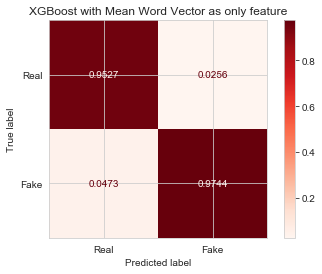

In [44]:
# Plot confusion matrix of XGBoost with word vector alone
plot_confusion_matrix(xgb_tester, vcdf_test, y_test,
                      display_labels=['Real', 'Fake'],
                      values_format='.4f',
                      cmap=plt.cm.Reds,
                      normalize='pred')
plt.title('XGBoost with Mean Word Vector as only feature')